In [ ]:
import numpy as np
import pandas as pd

In [ ]:


np.random.seed(42)

# Time period
n_periods = 100

# Generate synthetic data
time = np.arange(n_periods)
gdp_growth = np.sin(0.1 * time) + np.random.normal(scale=0.5, size=n_periods)
inflation = np.cos(0.1 * time) + np.random.normal(scale=0.3, size=n_periods)
unemployment = np.sin(0.1 * time + np.pi / 4) + np.random.normal(scale=0.4, size=n_periods)

# Create DataFrame
data = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation': inflation,
    'Unemployment': unemployment
})

data.index = pd.date_range(start='2000-01-01', periods=n_periods, freq='M')
data.head()


,GDP_Growth,Inflation,Unemployment
2000-01-31,0.248357,0.575389,0.850222
2000-02-29,0.030701,0.868811,0.998481
2000-03-31,0.522514,0.877252,1.266713
2000-04-30,1.057035,0.714653,1.306010
2000-05-31,0.272342,0.872675,0.375581


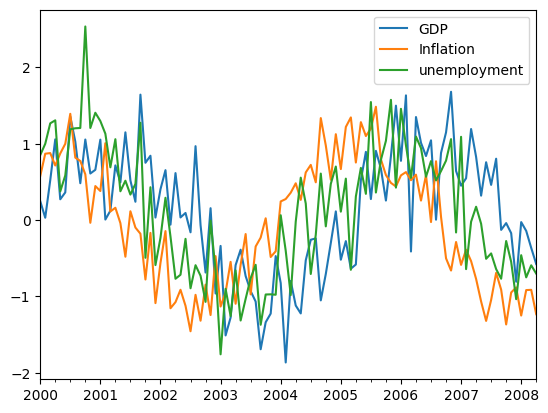

In [ ]:
axs = data['GDP_Growth'].plot(label = "GDP")
data["Inflation"].plot(label = "Inflation")
data["Unemployment"].plot(label ="unemployment")

plt.legend()
plt.show()

## VAR

A VAR model is a multivariate time series model that captures the linear interdependencies among multiple time series. Each variable in the system is modeled as a linear function of its own past values and the past values of all other variables in the system.


- Key Characteristics:

Multivariate: Designed to handle multiple time series simultaneously.
Lag Structure: Relies on specifying a lag length to determine the number of past observations to include in the model.

Stationarity: Assumes that the time series are stationary, or made stationary through differencing.

Interpretability: Provides clear interpretation through impulse response functions (IRFs) and variance decompositions.

- When to Use:

Multiple Interrelated Time Series: Use VAR when you have multiple time series that influence each other and you want to capture these interactions.

Short to Medium Term Forecasting: Effective for short to medium term forecasting where the relationships between variables are stable over time.

Policy Analysis: Useful for analyzing the impact of shocks or policy changes on the system (e.g., economic policy analysis).

- Example Use Cases:

Economic indicators (e.g., GDP, inflation, unemployment).

Financial markets (e.g., stock prices, interest rates, exchange rates).
Macroeconomic modeling.

In [ ]:
from statsmodels.tsa.api import VAR

# Fit the VAR model
model_var = VAR(data)
results_var = model_var.fit(maxlags=15, ic='aic')

# Print summary of the model
print(results_var.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jun, 2024
Time:                     01:51:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.55752
Nobs:                     86.0000    HQIC:                  -3.75740
Log likelihood:          -11.8074    FPE:                 0.00713171
AIC:                     -5.23904    Det(Omega_mle):      0.00211310
--------------------------------------------------------------------
Results for equation GDP_Growth
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.057007         0.045422           -1.255           0.209
L1.GDP_Growth            0.079512         0.129521            0.614           0.539
L1.Inflation            -0.631424         0

Coefficients: Each coefficient in the VAR model summary represents the relationship between the lagged values of one variable and the current value of another variable.

Significance: Look at the p-values for the coefficients. A small p-value (typically < 0.05) indicates that the corresponding lagged variable has a significant impact on the current variable.

In [ ]:
# Forecasting the next 10 periods
lag_order = results_var.k_ar
forecast_input = data.values[-lag_order:]
forecast = results_var.forecast(y=forecast_input, steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10, freq='M'),
                           columns=data.columns)

forecast_df


,GDP_Growth,Inflation,Unemployment
2008-05-31,-0.444827,-1.007415,-0.922600
2008-06-30,-0.277917,-1.132910,-0.920721
2008-07-31,-0.802029,-1.053155,-0.334647
2008-08-31,-1.080397,-0.490749,-1.053157
2008-09-30,-1.300791,-0.652427,-1.076386
2008-10-31,-0.803296,-0.710135,-0.801884
2008-11-30,-1.158552,-0.564915,-1.288408
2008-12-31,-1.375566,-0.378808,-0.934838
2009-01-31,-1.314638,-0.447126,-1.026704
2009-02-28,-1.127465,-0.192211,-1.182593


## Diagnostics: residual analysis, Ljung-Box test, and stability checks.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# # Loop over each time series in the residuals matrix
# for i, column in enumerate(results_var.resid.T):
#     lb_test = acorr_ljungbox(results_var.resid[:, i], lags=[10], return_df=True)
#     print(f"Ljung-Box test for series {data.columns[i]}:")
#     print(lb_test)
#     print()


# Check stability
print("Is the model stable?", results_var.is_stable())


Is the model stable? False


Residual Plots: Residuals should ideally be white noise. Plotting the residuals and performing the Ljung-Box test helps ensure this.

Ljung-Box Test: A high p-value suggests that the residuals are not autocorrelated, which is desired.

### Hypothesis Testing: Perform Granger causality, impulse response analysis, and variance decomposition.

Granger causality F-test. H_0: Inflation does not Granger-cause GDP_Growth. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         4.340          1.769   0.000 (14, 129)
-----------------------------------------------


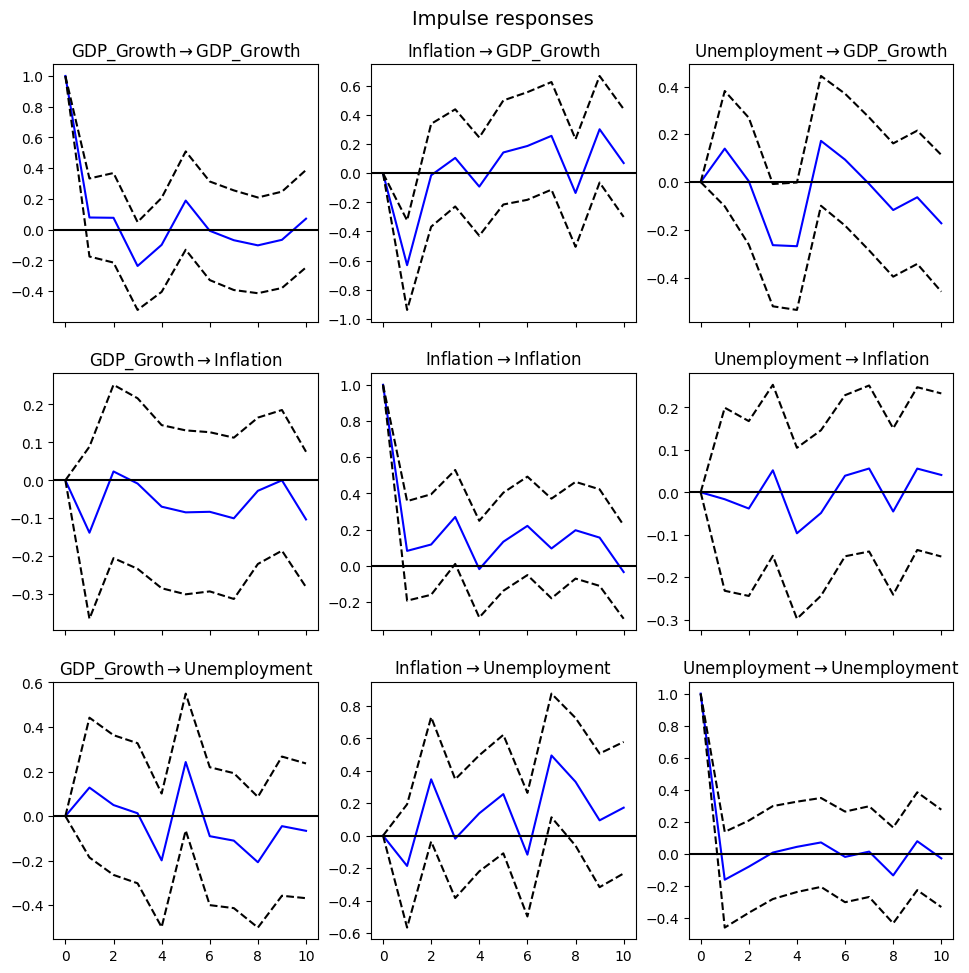

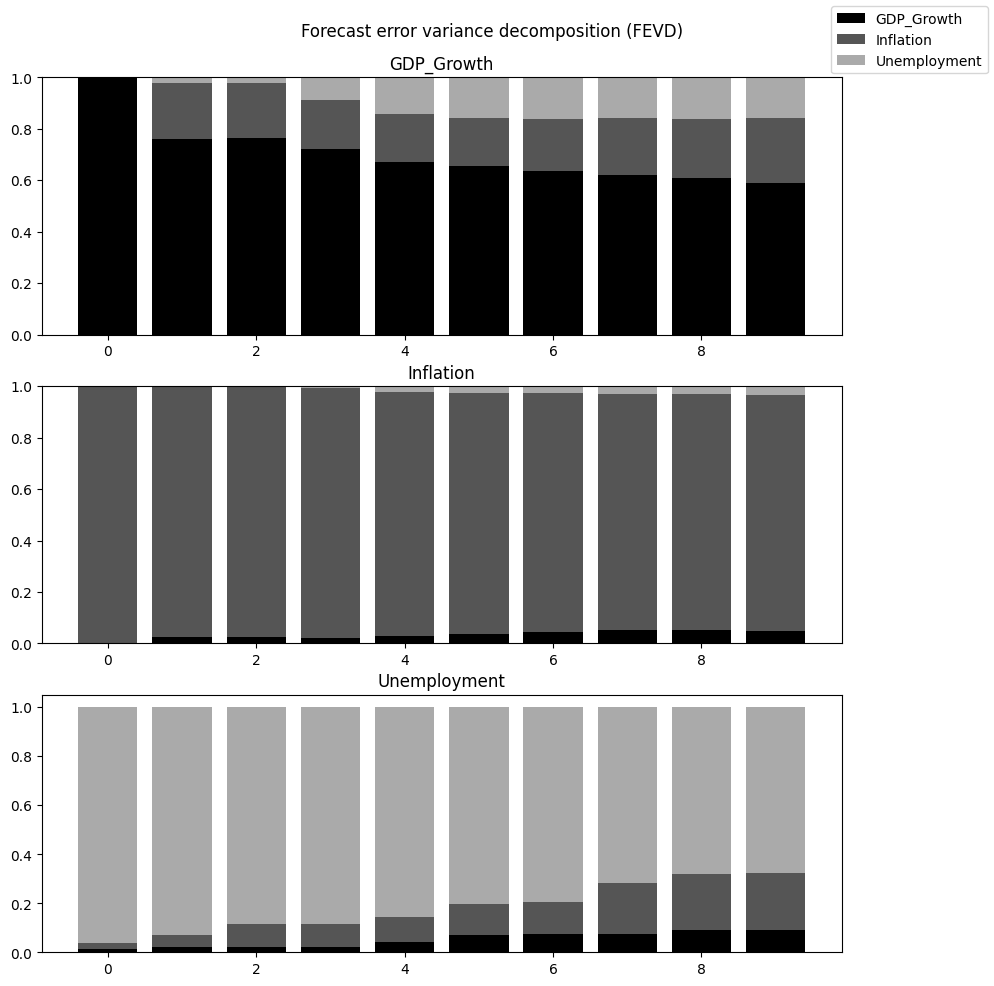

In [ ]:
# Granger causality test
granger_test = results_var.test_causality('GDP_Growth', 'Inflation', kind='f')
print(granger_test.summary())

# Impulse Response Function
irf = results_var.irf(10)
irf.plot(orth=False)
plt.show()

# Variance Decomposition
fevd = results_var.fevd(10)
fevd.plot()
plt.show()


Impulse Response Function (IRF)

Interpretation: IRFs show how a shock to one variable affects other variables over time. If GDP growth has a positive shock, IRFs can show the subsequent effect on inflation and unemployment.

Variance Decomposition

Interpretation: This tells you the proportion of the forecast error variance of each variable that is explained by innovations in the other variables.

Granger Causality

Interpretation: If the test indicates that one variable Granger-causes another, it suggests that past values of the first variable contain information that helps predict the second variable.

VAR Model

Coefficients: If the coefficient for lagged GDP growth in the inflation equation is positive and significant, it suggests that past GDP growth positively affects current inflation.

IRF: If the IRF shows that a shock to GDP growth leads to an increase in inflation for several periods, it suggests that economic growth is driving price increases.

Variance Decomposition: If the decomposition shows that a large portion of the forecast error variance of inflation is explained by GDP growth shocks, it indicates a strong influence of GDP growth on inflation.

## State Space

Description:

A State Space model represents a time series as a system of equations that describe the evolution of the hidden states over time. It consists of an observation equation and a state equation, which together model the observed data and the underlying state dynamics.

- Key Characteristics:

Flexibility: Can handle a wide range of time series patterns, including trends, seasonality, and structural breaks.

Unobserved Components: Models latent (unobserved) states, making it suitable for situations where the underlying process is not directly observable.

Kalman Filter: Typically uses the Kalman filter for estimation and forecasting, which is computationally efficient.

Non-Stationarity: Can handle non-stationary data through appropriate state space specifications.

- When to Use:

Complex Time Series Patterns:
Use State Space models when dealing with time series that exhibit complex patterns such as trends, seasonality, and regime changes.

Unobserved Components: Suitable when modeling latent variables or hidden states is essential (e.g., estimating potential GDP or underlying inflation).

Long Term Forecasting and Structural Analysis: Effective for long term forecasting and structural analysis where understanding the underlying process is crucial.

- Example Use Cases:

Forecasting and decomposing time series with trends and seasonality.
Modeling dynamic systems with hidden states (e.g., tracking the spread of a disease).
Economic modeling with unobserved components (e.g., potential output, natural rate of unemployment).

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a state space model (SARIMAX in this case) to GDP growth
model_ssm = SARIMAX(data['GDP_Growth'], order=(1, 1, 1))
results_ssm = model_ssm.fit()

# Print summary of the model
print(results_ssm.summary())


                               SARIMAX Results                                
Dep. Variable:             GDP_Growth   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -78.655
Date:                Wed, 05 Jun 2024   AIC                            163.310
Time:                        01:50:58   BIC                            171.095
Sample:                    01-31-2000   HQIC                           166.460
                         - 04-30-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0882      0.162     -0.544      0.586      -0.406       0.230
ma.L1         -0.6037      0.128     -4.714      0.000      -0.855      -0.353
sigma2         0.2852      0.043      6.586      0.0

Model Summary

Coefficients: The coefficients in the state space model summary indicate the relationship between the current value and its past values and error terms.

Significance: Look at the p-values for the coefficients to determine if they are statistically significant.

In [ ]:
# Forecasting the next 10 periods
forecast_ssm = results_ssm.get_forecast(steps=10)
forecast_ssm_mean = forecast_ssm.predicted_mean
forecast_ssm_ci = forecast_ssm.conf_int()

forecast_ssm_df = pd.DataFrame({
    'Forecast': forecast_ssm_mean,
    'Lower CI': forecast_ssm_ci.iloc[:, 0],
    'Upper CI': forecast_ssm_ci.iloc[:, 1]
}, index=pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10, freq='M'))

forecast_ssm_df


,Forecast,Lower CI,Upper CI
2008-05-31,-0.346584,-1.393260,0.700093
2008-06-30,-0.366725,-1.461926,0.728477
2008-07-31,-0.364947,-1.526281,0.796386
2008-08-31,-0.365104,-1.587233,0.857024
2008-09-30,-0.365090,-1.645278,0.915097
2008-10-31,-0.365092,-1.700804,0.970621
2008-11-30,-0.365091,-1.754113,1.023930
2008-12-31,-0.365091,-1.805450,1.075267
2009-01-31,-0.365091,-1.855019,1.124836
2009-02-28,-0.365091,-1.902991,1.172808


### Model Diagnostics: Analyze residuals and test for normality.

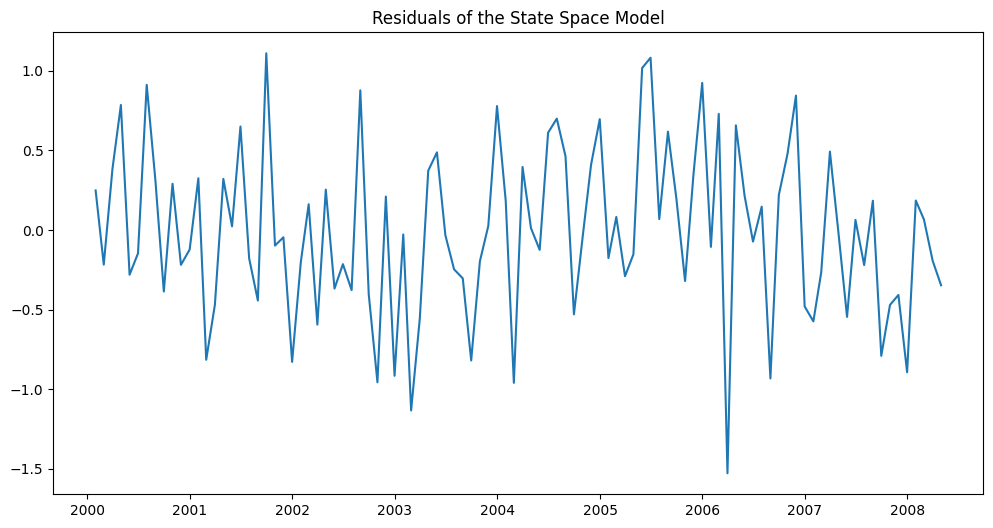

p-value for normality test: 0.9096252643647642


In [ ]:
# Check residuals
residuals_ssm = results_ssm.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_ssm)
plt.title('Residuals of the State Space Model')
plt.show()

# Check normality
from scipy.stats import normaltest

k2, p = normaltest(residuals_ssm)
print("p-value for normality test:", p)


Residual Analysis

Residual Plots: Check for patterns. Ideally, residuals should resemble white noise.



### Hypothesis Testing: Check parameter significance and evaluate forecast accuracy.

In [ ]:
# Print model summary for parameter significance
print(results_ssm.summary())

# Forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for the forecast
mae = mean_absolute_error(data['GDP_Growth'][-10:], forecast_ssm_df['Forecast'])
rmse = np.sqrt(mean_squared_error(data['GDP_Growth'][-10:], forecast_ssm_df['Forecast']))

print("MAE:", mae)
print("RMSE:", rmse)


                               SARIMAX Results                                
Dep. Variable:             GDP_Growth   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -78.655
Date:                Wed, 05 Jun 2024   AIC                            163.310
Time:                        02:04:46   BIC                            171.095
Sample:                    01-31-2000   HQIC                           166.460
                         - 04-30-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0882      0.162     -0.544      0.586      -0.406       0.230
ma.L1         -0.6037      0.128     -4.714      0.000      -0.855      -0.353
sigma2         0.2852      0.043      6.586      0.0

Normality Test: A high p-value in the normality test indicates that the residuals are normally distributed.

Forecast Accuracy

Metrics: Evaluate the model’s forecast accuracy using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). Lower values indicate better performance.

State Space Model

Coefficients: If the AR term in the GDP growth model is positive and significant, it suggests persistence in GDP growth (i.e., past GDP growth has a positive impact on current GDP growth).

Residuals: If residuals are normally distributed and resemble white noise, it suggests that the model captures the underlying data patterns well.

Forecast Accuracy: Lower MAE and RMSE values indicate that the model provides accurate forecasts for GDP growth.

## Compare

- Use VAR if you have multiple interrelated time series and are interested in understanding their linear relationships and interactions over time. It is particularly suitable for short to medium term forecasting and policy analysis where the relationships between variables are crucial.

- Use State Space Models if your time series data exhibit complex patterns, non-stationarity, or involve latent variables that you wish to estimate. These models are versatile and suitable for long term forecasting and structural analysis where understanding the underlying dynamics is important.

- VAR Model: If the 10 series are believed to have strong interdependencies and you are interested in modeling the relationships between these series, a VAR model is suitable. VAR models excel at capturing the linear relationships between multiple time series and can provide insights into how shocks to one series affect the others.

- State Space Model: If the primary interest is in understanding the underlying structure of each series (such as trends, cycles, or seasonal patterns) and you suspect there are latent factors influencing the observed data, a State Space model may be more appropriate. State Space models are also beneficial if you need to handle structural breaks or complex dynamics within each series.

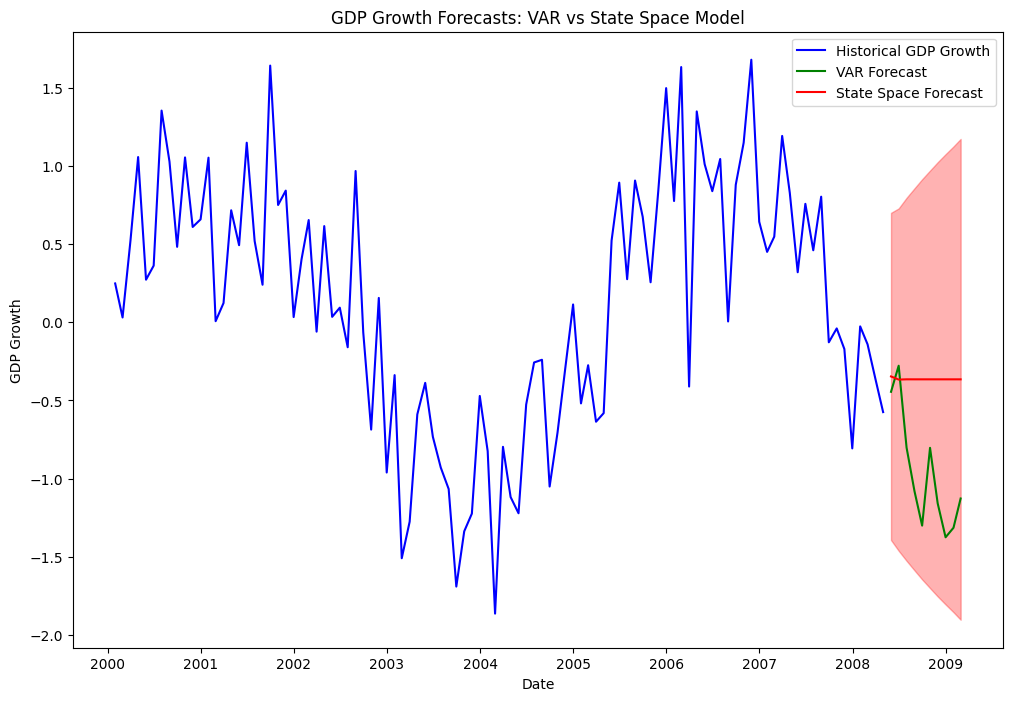

In [ ]:
import matplotlib.pyplot as plt

# Plot the historical data and forecasts
plt.figure(figsize=(12, 8))

# Historical data
plt.plot(data['GDP_Growth'], label='Historical GDP Growth', color='blue')

# VAR forecasts
plt.plot(forecast_df['GDP_Growth'], label='VAR Forecast', color='green')

# State space forecasts
plt.plot(forecast_ssm_df['Forecast'], label='State Space Forecast', color='red')
plt.fill_between(forecast_ssm_df.index, forecast_ssm_df['Lower CI'], forecast_ssm_df['Upper CI'], color='red', alpha=0.3)

plt.legend()
plt.xlabel('Date')
plt.ylabel('GDP Growth')
plt.title('GDP Growth Forecasts: VAR vs State Space Model')
plt.show()


## DTW

In [4]:
pip install dtaidistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.4 MB/s eta 0:00:00


In [5]:
from dtaidistance import dtw
import numpy as np

# Sample data
series1 = np.array([1, 2, 3, 4, 5, 6, 7], dtype=np.double)
series2 = np.array([2, 3, 4, 5, 6, 7, 8], dtype=np.double)

# Calculate DTW distance
distance = dtw.distance(series1, series2)

print("DTW distance:", distance)


DTW distance: 1.4142135623730951


In [6]:
pip install tslearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.5 MB/s eta 0:00:00


In [7]:
from tslearn.metrics import dtw as tslearn_dtw

# Sample data
series1 = np.array([1, 2, 3, 4, 5, 6, 7]).reshape(-1, 1)
series2 = np.array([2, 3, 4, 5, 6, 7, 8]).reshape(-1, 1)

# Calculate DTW distance using tslearn
distance = tslearn_dtw(series1, series2)

print("DTW distance:", distance)


DTW distance: 1.4142135623730951


In [8]:
def dtw_distance(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(series1[i-1] - series2[j-1])
            last_min = min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[n, m]

# Sample data
series1 = np.array([1, 2, 3, 4, 5, 6, 7])
series2 = np.array([2, 3, 4, 5, 6, 7, 8])

# Calculate DTW distance
distance = dtw_distance(series1, series2)
print("DTW distance:", distance)


DTW distance: 2.0


DTW distance: 2.0


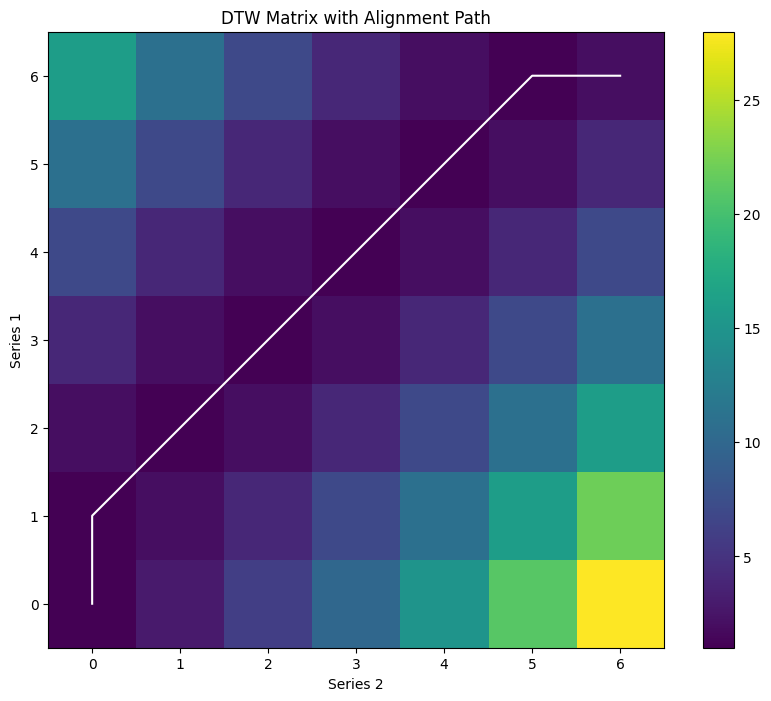

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def dtw_distance(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(series1[i-1] - series2[j-1])
            last_min = min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
            dtw_matrix[i, j] = cost + last_min

    # Backtrack to find the optimal path
    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        if i == 1:
            j -= 1
        elif j == 1:
            i -= 1
        else:
            step = np.argmin((dtw_matrix[i-1, j-1], dtw_matrix[i-1, j], dtw_matrix[i, j-1]))
            if step == 0:
                i -= 1
                j -= 1
            elif step == 1:
                i -= 1
            else:
                j -= 1
    path.append((0, 0))
    path.reverse()

    return dtw_matrix[1:, 1:], path

# Sample data
series1 = np.array([1, 2, 3, 4, 5, 6, 7])
series2 = np.array([2, 3, 4, 5, 6, 7, 8])

# Calculate DTW distance and path
dtw_matrix, path = dtw_distance(series1, series2)
distance = dtw_matrix[-1, -1]
print("DTW distance:", distance)

# Visualize the DTW matrix and the alignment path
plt.figure(figsize=(10, 8))
plt.imshow(dtw_matrix, origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('DTW Matrix with Alignment Path')
plt.xlabel('Series 2')
plt.ylabel('Series 1')

# Plot the alignment path
path_x, path_y = zip(*path)
plt.plot(path_y, path_x, 'w')

plt.show()


In [12]:
series1 = np.array([1, 2, 3, 4, 5, 6, 7])
series2 = np.array([1, 2, 3, 4, 5, 6, 7])

# Calculate DTW distance and path
dtw_matrix, path = dtw_distance(series1, series2)
dtw_matrix[-1,-1]

0.0